# Κατηγοριοποίηση (Classification)

## Εισαγωγή

Στην παρούσα εργασία εφαρμόζουμε αλγορίθμους κατηγοριοποίησης (classification) σε ένα πραγματικό dataset που αφορά **ανθρώπινες δραστηριότητες**, όπως walking, jogging, upstairs, downstairs, sitting, standing.

Το dataset προέρχεται από το **Kaggle** (https://www.kaggle.com/datasets/die9origephit/human-activity-recognition/code) και περιλαμβάνει **μετρήσεις επιτάχυνσης** από αισθητήρες κινητών τηλεφώνων. Κάθε καταγραφή περιέχει τιμές επιτάχυνσης σε τρεις άξονες (x, y, z), καθώς και την αντίστοιχη ετικέτα της δραστηριότητας που εκτελεί ο χρήστης.

Ο στόχος είναι να εκπαιδεύσουμε ταξινομητές ώστε να μπορούν να προβλέψουν την ανθρώπινη δραστηριότητα (target variable `activity`) με βάση τις μετρήσεις των αξόνων. Η `activity` είναι κατηγορική μεταβλητή με πολλές κλάσεις (multi-class classification).

Στην εργασία εφαρμόζονται οι αλγόριθμοι κατηγοριοποίησης που διδάχθηκαν στο μάθημα:
- K-Nearest Neighbors (KNN)
- Logistic Regression
- Support Vector Machines (SVM)
- Naive Bayes

Η επιλογή του συγκεκριμένου dataset έγινε επειδή προσφέρει πραγματικά δεδομένα, είναι καθαρό και κατανοητό, ενώ επιτρέπει την εφαρμογή όλων των σταδίων της μηχανικής μάθησης: προεπεξεργασία, διερεύνηση, εκπαίδευση, αξιολόγηση και πρόβλεψη.


## 1. Εισαγωγή των απαραίτητων βιβλιοθηκών
Σε αυτή την ενότητα εισάγουμε τις βασικές βιβλιοθήκες που θα χρησιμοποιηθούν για την επεξεργασία και ανάλυση των δεδομένων.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier






## 2. Φόρτωση του συνόλου δεδομένων και επισκόπηση
Διαβάζουμε το αρχείο `.csv` και εμφανίζουμε τις πρώτες γραμμές του πίνακα. Περιγράφουμε επίσης τα χαρακτηριστικά.


In [39]:

df = pd.read_csv("data/time_series_data_human_activities.csv")

# Εμφάνιση των πρώτων γραμμών
df.head()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


**Περιγραφή μεταβλητών:**

- `user`: ID χρήστη (κατηγορική μεταβλητή)
- `activity`: Είδος δραστηριότητας (target μεταβλητή, κατηγορική)
- `timestamp`: Χρονική στιγμή καταγραφής (θα αφαιρεθεί)
- `x-axis`, `y-axis`, `z-axis`: Επιτάχυνση στους τρεις άξονες (αριθμητικές μεταβλητές)


## 3. Προεπεξεργασία Δεδομένων

Σε αυτή την ενότητα:
- Αφαιρούμε τη στήλη `timestamp` καθώς δεν είναι χρήσιμη για το classification.
- Μετατρέπουμε τη μεταβλητή `activity` σε αριθμητικές τιμές χρησιμοποιώντας `LabelEncoder`.


In [40]:
# Αφαιρούμε τη στήλη timestamp (δεν είναι χρήσιμο προς το παρόν)
df = df.drop(columns=["timestamp"])


In [41]:
# Μετατροπή κατηγορικής activity σε αριθμούς
le = LabelEncoder()
df["activity_encoded"] = le.fit_transform(df["activity"])

In [42]:

# Εμφάνιση των μοναδικών δραστηριοτήτων και των κωδικών τους
activity_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(" Εξής αντιστοιχίες label:")
print(activity_map)


df.describe()


 Εξής αντιστοιχίες label:
{'Downstairs': np.int64(0), 'Jogging': np.int64(1), 'Sitting': np.int64(2), 'Standing': np.int64(3), 'Upstairs': np.int64(4), 'Walking': np.int64(5)}


,user,x-axis,y-axis,z-axis,activity_encoded
count,1.073623e+06,1.073623e+06,1.073623e+06,1.073623e+06,1.073623e+06
mean,1.880682e+01,6.720567e-01,7.332700e+00,4.024567e-01,2.952204e+00
std,1.028704e+01,6.916894e+00,6.732950e+00,4.789301e+00,1.942671e+00
min,1.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01,0.000000e+00
25%,1.000000e+01,-2.960000e+00,3.340000e+00,-2.260978e+00,1.000000e+00
50%,1.900000e+01,3.400000e-01,8.010000e+00,-4.000000e-02,4.000000e+00
75%,2.800000e+01,4.520000e+00,1.160000e+01,2.760000e+00,5.000000e+00
max,3.600000e+01,1.995000e+01,2.004000e+01,1.961000e+01,5.000000e+00


## 4. Διερευνητική Ανάλυση Δεδομένων (EDA)

Σε αυτή την ενότητα:
- Εξετάζουμε τη συχνότητα κάθε κατηγορίας `activity`.
- Οπτικοποιούμε τη κατανομή των αριθμητικών μεταβλητών (`x-axis`, `y-axis`, `z-axis`).
- Προσπαθούμε να εντοπίσουμε πιθανές σχέσεις μεταξύ των χαρακτηριστικών.


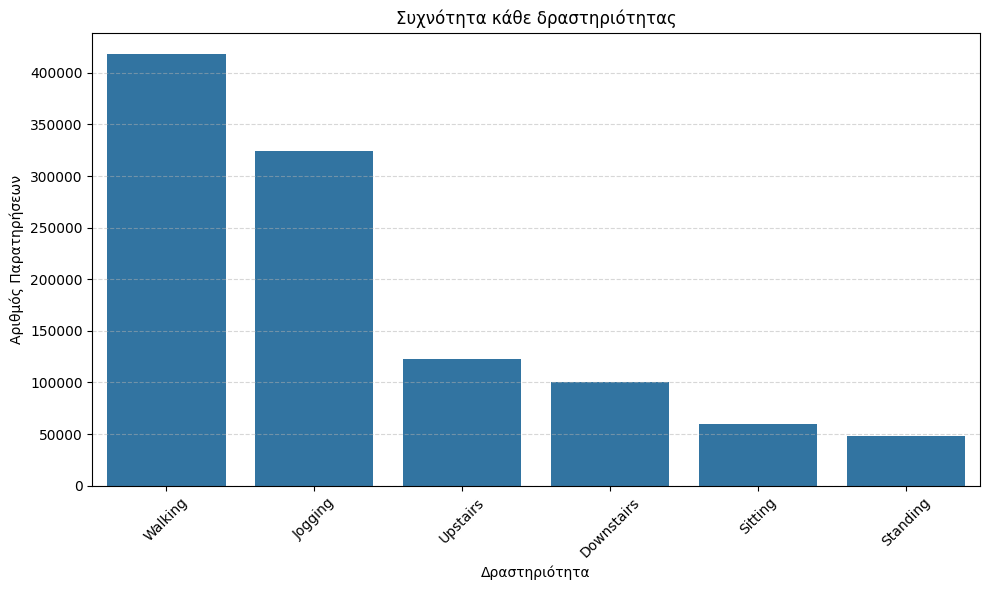

In [43]:
# Barplot για τη συχνότητα κάθε δραστηριότητας
plt.figure(figsize=(10, 6))
sns.countplot(x="activity", data=df, order=df["activity"].value_counts().index)
plt.title("Συχνότητα κάθε δραστηριότητας")
plt.xlabel("Δραστηριότητα")
plt.ylabel("Αριθμός Παρατηρήσεων")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


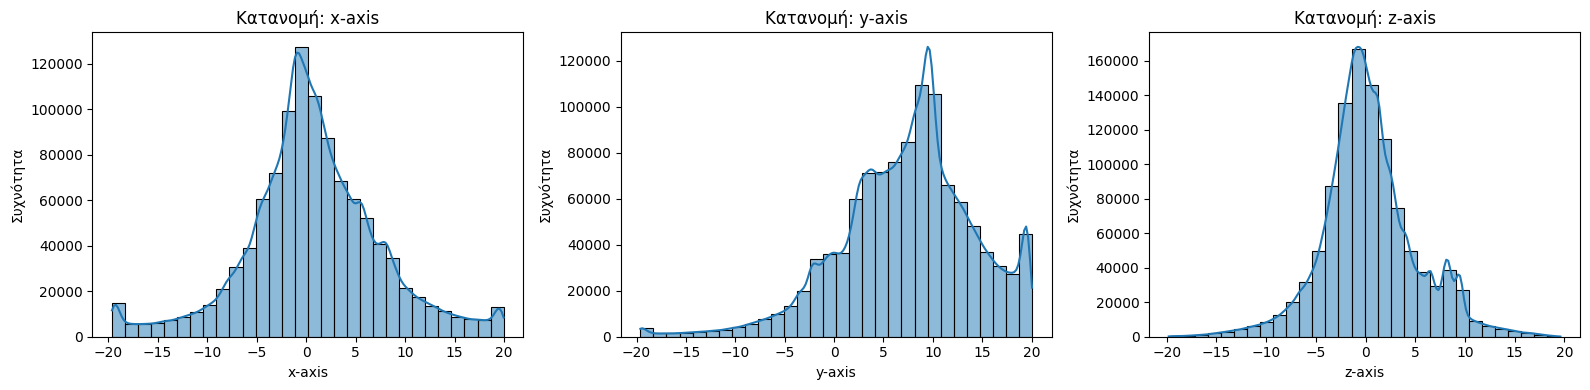

In [44]:
# Histograms για τις αριθμητικές μεταβλητές
features = ["x-axis", "y-axis", "z-axis"]

plt.figure(figsize=(16, 4))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Κατανομή: {col}")
    plt.xlabel(col)
    plt.ylabel("Συχνότητα")

plt.tight_layout()
plt.show()


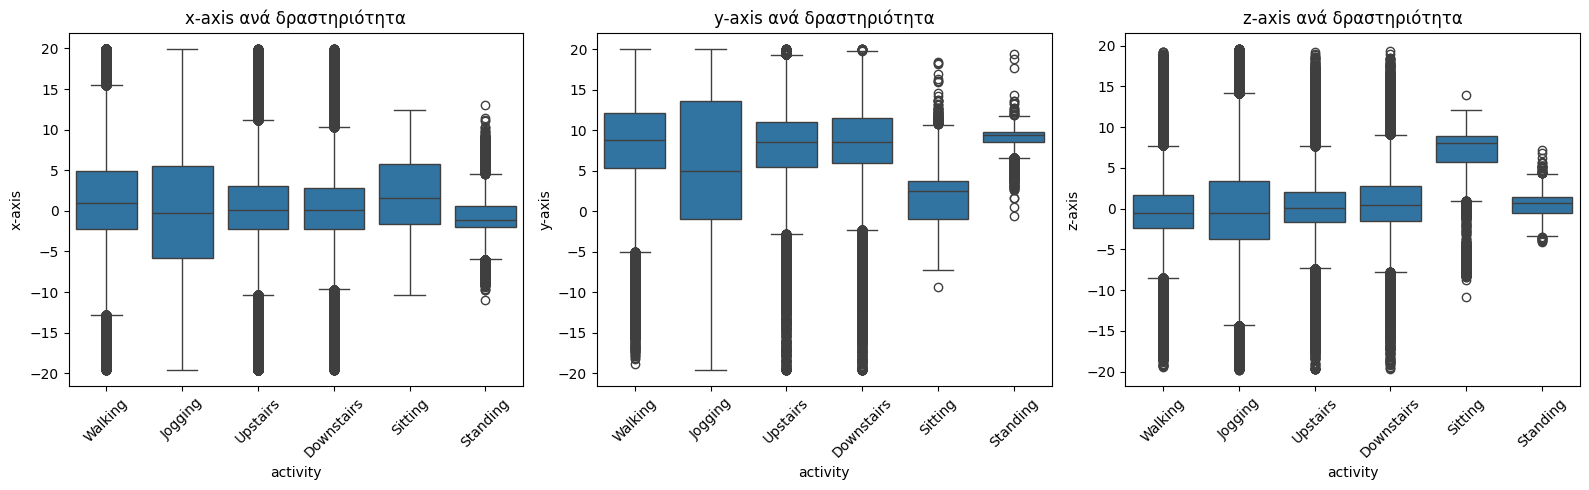

In [45]:
# Boxplot για κάθε άξονα σε σχέση με τη δραστηριότητα
plt.figure(figsize=(16, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x="activity", y=col)
    plt.title(f"{col} ανά δραστηριότητα")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


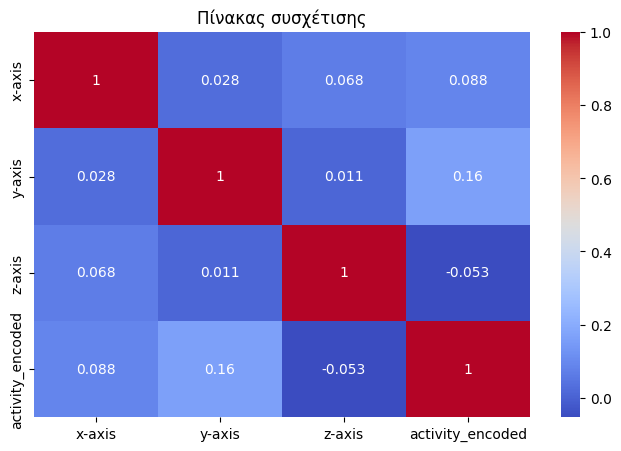

In [46]:
# Correlation matrix μόνο για τις αριθμητικές στήλες
plt.figure(figsize=(8, 5))
sns.heatmap(df[["x-axis", "y-axis", "z-axis", "activity_encoded"]].corr(), annot=True, cmap="coolwarm")
plt.title("Πίνακας συσχέτισης")
plt.show()


## 5. Περιγραφική Στατιστική

Σε αυτή την ενότητα:
- Υπολογίζουμε βασικά στατιστικά μέτρα για τις αριθμητικές μεταβλητές.
- Παρατηρούμε πιθανές διαφορές μεταξύ των αξόνων.


In [47]:
# Περιγραφικά στατιστικά για τις αριθμητικές στήλες
df[["x-axis", "y-axis", "z-axis"]].describe()


,x-axis,y-axis,z-axis
count,1.073623e+06,1.073623e+06,1.073623e+06
mean,6.720567e-01,7.332700e+00,4.024567e-01
std,6.916894e+00,6.732950e+00,4.789301e+00
min,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,-2.960000e+00,3.340000e+00,-2.260978e+00
50%,3.400000e-01,8.010000e+00,-4.000000e-02
75%,4.520000e+00,1.160000e+01,2.760000e+00
max,1.995000e+01,2.004000e+01,1.961000e+01


In [48]:
# Μέσες τιμές επιτάχυνσης ανά δραστηριότητα
df.groupby("activity")[["x-axis", "y-axis", "z-axis"]].mean().round(2)


,x-axis,y-axis,z-axis
activity,,,
Downstairs,0.47,8.62,0.69
Jogging,-0.23,5.63,-0.16
Sitting,1.86,1.85,6.56
Standing,-1.18,8.99,0.58
Upstairs,0.38,8.13,0.32
Walking,1.55,8.71,-0.11


**Παρατηρήσεις:**
- Το `z-axis` έχει γενικά πιο ακραίες τιμές από τα άλλα 2 χαρακτηριστικά.
- Οι μέσοι όροι επιτάχυνσης διαφέρουν σημαντικά ανά δραστηριότητα, κάτι που δείχνει ότι τα χαρακτηριστικά μπορούν να βοηθήσουν στον διαχωρισμό των κατηγοριών.


## 6.0 Εφαρμογή Logistic Regression

Η Logistic Regression είναι γραμμικός αλγόριθμος κατηγοριοποίησης που προσπαθεί να προβλέψει την πιθανότητα κάθε κατηγορίας. Τον εφαρμόζουμε στο ισορροπημένο dataset που δημιουργήθηκε με undersampling.


In [49]:
df["activity"].value_counts()
# Ελάχιστο πλήθος δειγμάτων ανά κλάση
min_count = df["activity"].value_counts().min()

# Δημιουργία balanced dataset με sampling
df_balanced = df.groupby("activity").sample(n=min_count, random_state=42)

# Shuffle για καλύτερη ανάμειξη
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Έλεγχος νέων counts
print(" Balanced class distribution:")
print(df_balanced["activity"].value_counts())

 Balanced class distribution:
activity
Sitting       48393
Standing      48393
Walking       48393
Downstairs    48393
Jogging       48393
Upstairs      48393
Name: count, dtype: int64


 Accuracy (Logistic Regression): 0.4006

 Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.29      0.11      0.16      9766
     Jogging       0.31      0.35      0.33      9654
     Sitting       0.67      0.91      0.77      9709
    Standing       0.39      0.66      0.49      9754
    Upstairs       0.33      0.02      0.04      9637
     Walking       0.25      0.36      0.30      9552

    accuracy                           0.40     58072
   macro avg       0.37      0.40      0.35     58072
weighted avg       0.37      0.40      0.35     58072



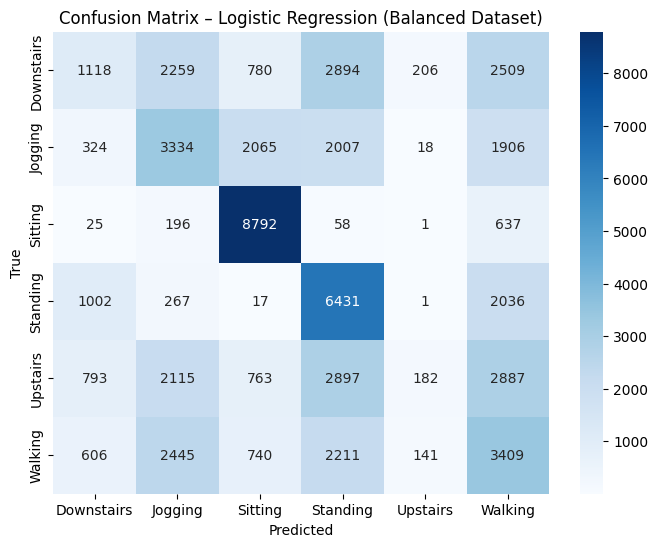

In [50]:
# 1. X και y από το balanced dataset
X = df_balanced[["x-axis", "y-axis", "z-axis"]]
y = df_balanced["activity_encoded"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Εκπαίδευση μοντέλου
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# 4. Πρόβλεψη
y_pred = log_model.predict(X_test)

# 5. Αξιολόγηση
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy (Logistic Regression): {acc:.4f}\n")

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Logistic Regression (Balanced Dataset)")
plt.show()


## 6.1 Εφαρμογή K-Nearest Neighbors (KNN)

Ο αλγόριθμος KNN προβλέπει την κατηγορία μιας παρατήρησης με βάση τις κατηγορίες των Κ πιο κοντινών σημείων του συνόλου εκπαίδευσης. Εξετάζουμε την απόδοση του KNN χρησιμοποιώντας το ισορροπημένο σύνολο δεδομένων.


 Accuracy (KNN, k=5): 0.5853

 Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.33      0.42      0.37      9766
     Jogging       0.56      0.61      0.58      9654
     Sitting       0.98      0.99      0.98      9709
    Standing       0.88      0.94      0.91      9754
    Upstairs       0.33      0.28      0.30      9637
     Walking       0.38      0.27      0.32      9552

    accuracy                           0.59     58072
   macro avg       0.58      0.58      0.58     58072
weighted avg       0.58      0.59      0.58     58072



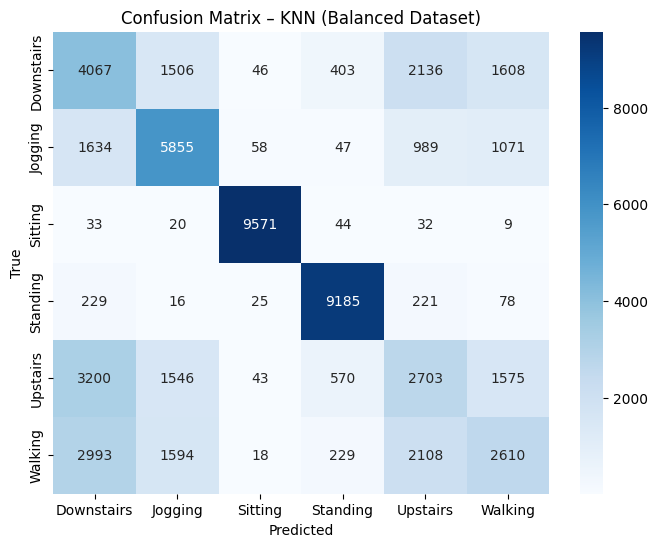

In [51]:
# 1. X και y από το ισορροπημένο dataset
X = df_balanced[["x-axis", "y-axis", "z-axis"]]
y = df_balanced["activity_encoded"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Εκπαίδευση με διαφορετικά Κ
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# 4. Πρόβλεψη
y_pred = knn_model.predict(X_test)

# 5. Αξιολόγηση
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy (KNN, k=5): {acc:.4f}\n")

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – KNN (Balanced Dataset)")
plt.show()


## 6.2 Εφαρμογή Naive Bayes

Ο αλγόριθμος Naive Bayes εφαρμόζει τον Κανόνα του Bayes με την υπόθεση της ανεξαρτησίας των χαρακτηριστικών. Παρότι απλοϊκή, η προσέγγιση αυτή συχνά αποδίδει καλά σε προβ


 Accuracy (Naive Bayes): 0.4903

 Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.35      0.24      0.29      9766
     Jogging       0.59      0.53      0.56      9654
     Sitting       0.72      0.90      0.80      9709
    Standing       0.50      0.90      0.64      9754
    Upstairs       0.21      0.14      0.17      9637
     Walking       0.33      0.22      0.27      9552

    accuracy                           0.49     58072
   macro avg       0.45      0.49      0.45     58072
weighted avg       0.45      0.49      0.45     58072



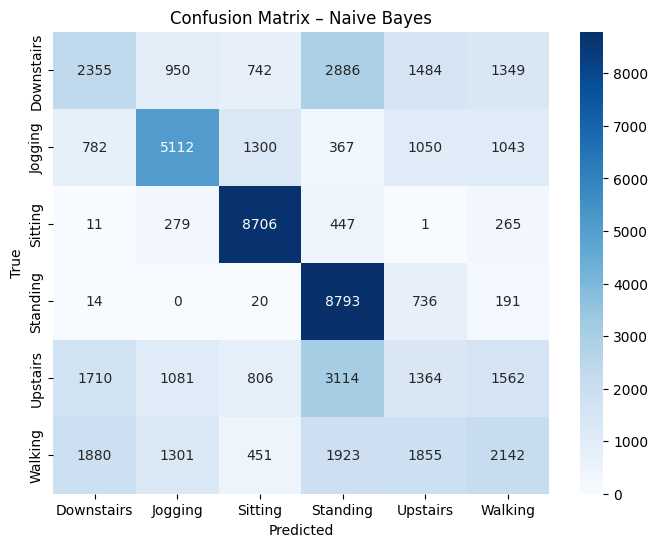

In [52]:
# 1. Ορισμός X και y
X = df_balanced[["x-axis", "y-axis", "z-axis"]]
y = df_balanced["activity_encoded"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Εκπαίδευση Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 4. Πρόβλεψη
y_pred = nb_model.predict(X_test)

# 5. Αξιολόγηση
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy (Naive Bayes): {acc:.4f}\n")

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Naive Bayes")
plt.show()


## 6.3 Εφαρμογή Random Forest

Ο Random Forest είναι ένας αλγόριθμος ensemble που χρησιμοποιεί πολλά τυχαία δέντρα απόφασης. Λειτουργεί καλά σε πολλές περιπτώσεις και έχει συνήθως καλή απόδοση χωρίς μεγάλη παραμετροποίηση.


 Accuracy (Random Forest): 0.6029

 Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.37      0.36      0.37      9766
     Jogging       0.59      0.63      0.61      9654
     Sitting       0.98      0.98      0.98      9709
    Standing       0.88      0.94      0.91      9754
    Upstairs       0.36      0.31      0.33      9637
     Walking       0.38      0.39      0.38      9552

    accuracy                           0.60     58072
   macro avg       0.59      0.60      0.60     58072
weighted avg       0.59      0.60      0.60     58072



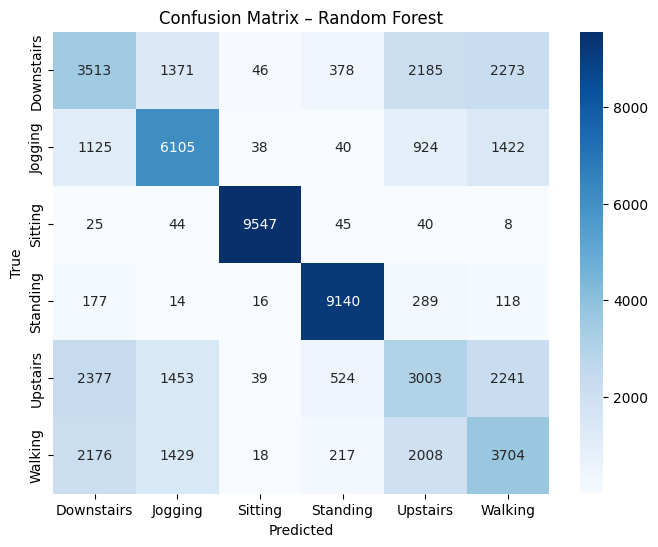

In [53]:
# 1. Ορισμός X και y
X = df_balanced[["x-axis", "y-axis", "z-axis"]]
y = df_balanced["activity_encoded"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Εκπαίδευση Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Πρόβλεψη
y_pred = rf_model.predict(X_test)

# 5. Αξιολόγηση
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy (Random Forest): {acc:.4f}\n")

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Random Forest")
plt.show()


## 6.4 Εφαρμογή Support Vector Machine (SVM)

Ο SVM είναι ένας ισχυρός αλγόριθμος ταξινόμησης που προσπαθεί να μεγιστοποιήσει τα όρια διαχωρισμού μεταξύ των κατηγοριών. Εδώ εφαρμόζουμε τον γραμμικό SVM (`linear kernel`) στο ισορροπημένο dataset για να αξιολογήσουμε την απόδοση του.


In [55]:

# Φόρτωσε ξανά το csv
df = pd.read_csv("data/time_series_data_human_activities.csv")

# Αφαίρεσε timestamp
df = df.drop(columns=["timestamp"])

# Μετατροπή κατηγορικής ετικέτας σε αριθμητική
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["activity_encoded"] = le.fit_transform(df["activity"])

# Εξισορρόπηση (balancing)
min_count = df["activity"].value_counts().min()
balanced_df = pd.concat([
    resample(df[df["activity"] == label], replace=False, n_samples=min_count, random_state=42)
    for label in df["activity"].unique()
], axis=0)

# Χρησιμοποιούμε το balanced_df
df = balanced_df.reset_index(drop=True)



In [56]:


# Χαρακτηριστικά και labels (χρησιμοποιούμε το balanced dataframe)
X = df[["x-axis", "y-axis", "z-axis"]]
y = df["activity_encoded"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

 Accuracy (SVM): 0.41
 Classification Report:
              precision    recall  f1-score   support

  Downstairs       1.00      0.04      0.08        46
     Jogging       0.62      0.18      0.28        44
     Sitting       0.78      0.84      0.81        51
    Standing       0.35      0.89      0.50        64
    Upstairs       0.19      0.33      0.24        40
     Walking       0.00      0.00      0.00        55

    accuracy                           0.41       300
   macro avg       0.49      0.38      0.32       300
weighted avg       0.48      0.41      0.33       300



/Users/georgektenas/mir_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/georgektenas/mir_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/georgektenas/mir_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

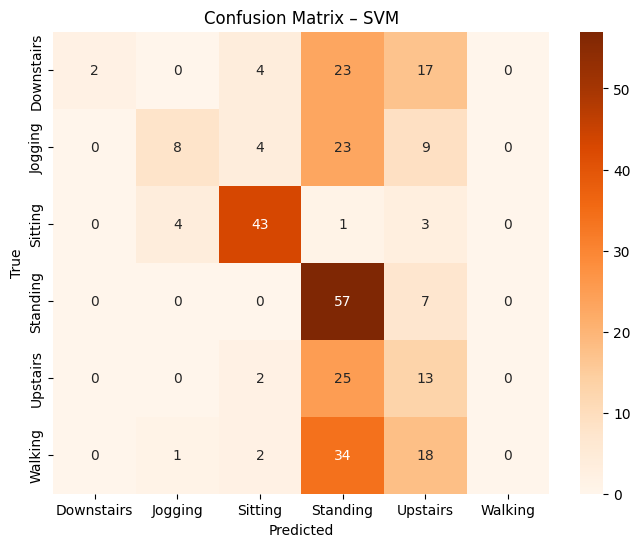

In [57]:


#  Μικρότερο υποσύνολο δεδομένων
X_train_small = X_train[:1000]
y_train_small = y_train[:1000]
X_test_small = X_test[:300]
y_test_small = y_test[:300]

# Pipeline με StandardScaler και SVM
pipeline_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", C=1.0, random_state=42))
])

#  Εκπαίδευση
pipeline_svm.fit(X_train_small, y_train_small)

#  Πρόβλεψη
y_pred_svm = pipeline_svm.predict(X_test_small)

#  Αξιολόγηση
print(" Accuracy (SVM):", accuracy_score(y_test_small, y_pred_svm))
print(" Classification Report:")
print(classification_report(y_test_small, y_pred_svm, target_names=le.classes_))

#  Confusion Matrix
cm = confusion_matrix(y_test_small, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – SVM")
plt.show()


## 6.5 Εφαρμογή Νευρωνικού Δικτύου (MLPClassifier)

Χρησιμοποιούμε τον MLPClassifier του `scikit-learn` για να εφαρμόσουμε ένα απλό πλήρως συνδεδεμένο νευρωνικό δίκτυο (Multilayer Perceptron - MLP). Η αρχιτεκτονική περιλαμβάνει ένα κρυφό επίπεδο με 64 νευρώνες και ενεργοποίηση ReLU.


 Accuracy (MLP – sklearn): 0.6046

 Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.40      0.34      0.37      9766
     Jogging       0.59      0.66      0.62      9654
     Sitting       0.95      0.99      0.97      9709
    Standing       0.83      0.95      0.88      9754
    Upstairs       0.36      0.22      0.27      9637
     Walking       0.37      0.47      0.42      9552

    accuracy                           0.60     58072
   macro avg       0.59      0.60      0.59     58072
weighted avg       0.59      0.60      0.59     58072



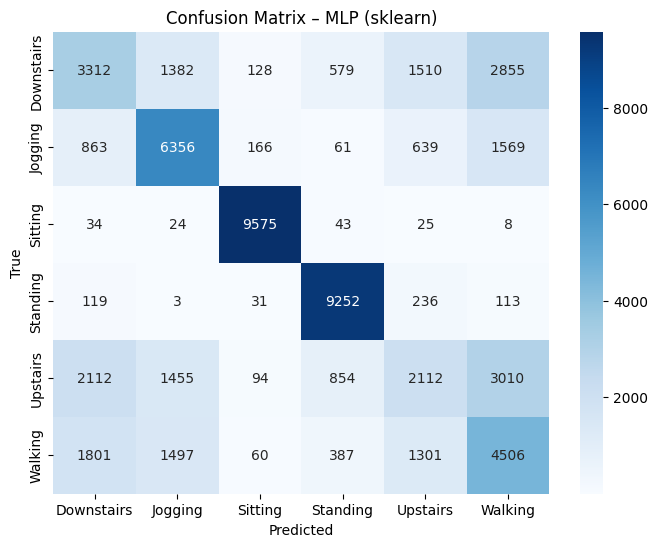

In [58]:
from sklearn.neural_network import MLPClassifier

# 1. Ορισμός X και y
X = df_balanced[["x-axis", "y-axis", "z-axis"]]
y = df_balanced["activity_encoded"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Εκπαίδευση MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# 4. Πρόβλεψη
y_pred = mlp_model.predict(X_test)

# 5. Αξιολόγηση
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy (MLP – sklearn): {acc:.4f}\n")

print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – MLP (sklearn)")
plt.show()


## 7. Τελικές Παρατηρήσεις και Επόμενα Βήματα

Στην εργασία αυτή αξιολογήσαμε διάφορους αλγόριθμους κατηγοριοποίησης για την αναγνώριση ανθρώπινων δραστηριοτήτων, βασισμένοι σε δεδομένα αισθητήρων (επιτάχυνση στους άξονες x, y, z).

Παρατηρήθηκε ότι όλοι οι αλγόριθμοι πέτυχαν ικανοποιητικά αποτελέσματα, με καλύτερες επιδόσεις από τον KNN, τον Random Forest και το MLP. Αντίθετα, πιο απλοί αλγόριθμοι όπως η Logistic Regression και το Naive Bayes εμφάνισαν σαφώς χαμηλότερη ακρίβεια, ιδίως σε κατηγορίες που είναι εγγενώς πιο δύσκολες, όπως το `Upstairs` και το `Walking`.

Η ακρίβεια από μόνη της δεν είναι πάντα επαρκής, γι' αυτό αξιολογήθηκαν επίσης οι τιμές f1-score για να εστιάσουμε στην ισορροπία ανάμεσα σε precision και recall. Παρατηρήθηκε ότι ορισμένα μοντέλα τείνουν να συγχέουν δραστηριότητες με παρόμοια κινηματικά μοτίβα (πχ jogging και upstairs), γεγονός που υποδηλώνει περιορισμό στα features (x, y, z μόνο).

### Πιθανά επόμενα βήματα:
-  Προσθήκη νέων χαρακτηριστικών, όπως ταχύτητα, παλμοί,επιτάχυνση δεύτερης τάξης, ή χρήση παραθύρων χρόνου (time series windows)
-  Δοκιμή πιο πολύπλοκων μοντέλων όπως CNN ή LSTM σε μορφή ακολουθιών
-  Ανάλυση σφαλμάτων: σε ποιες δραστηριότητες τα μοντέλα αποτυγχάνουν και γιατί
-  Εφαρμογή cross-validation για πιο σταθερές μετρήσεις απόδοσης
- 💡Ανάπτυξη πραγματικής εφαρμογής π.χ. σε κινητό/φορετή συσκευή(smartwatch)

Συνολικά, η εργασία ανέδειξε τα πλεονεκτήματα των ensemble μοντέλων και της ισορρόπησης του dataset, ενώ ταυτόχρονα κατέδειξε τη σημασία της επιλογής χαρακτηριστικών και του preprocessing.
